**<font size="+3">07 Zeitreihendekomposition</font>**

https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7

In [2]:
import pandas as pd
import numpy as np
import datetime
import math     # zur Erzeugung des Kosinus
from IPython.display import display

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

In [4]:
from statsmodels.graphics.tsaplots import plot_acf  # zum plotten der Autokorrelationsfunktion

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose # für Zeitreihendekomposition

In [6]:
passengers = pd.read_csv('data/airline-passengers.csv', index_col='Month', parse_dates=True)

# Einführung

**Was ist Zeitreihendekomposition?**  
<ul>
<li>Eine Zeitreihe wird in die Anteile: Trend, Saison, Residuals aufgeteilt
<li>Trend: langfristige Entwicklung
<li>Saison: Darstellung eines saisonalen, periodischen Verhaltens
<li>Residual: Alles was nicht mit Trend oder Saison erklärbar ist
</ul>

**Warum macht man das?**  
<ul>
<li>Separate Betrachtung von Trend und Saison ist häufig leichter
<li>eine Möglichkeit eine stationäre Zeitreihe zu erzeugen
</ul>

**Im nächsten Abschnitt werden zunächst Trend-, Saison- und Residuals additiv und multiplikativ verknüpft, und dann wird versucht, die einzelnen Komponenten wieder zu separieren.**

# Erzeugung von Zeitreihen

## Trend und Saison: additiv

**Erzeugung Datatimeindex (ab 01.01.2010, 120 Monate)**

In [7]:
start = pd.Timestamp(2010, 1, 1)
dti = pd.date_range(start, periods= 10*12, freq='MS')  # MS month start
dti

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', length=120, freq='MS')

**Erzeugung Trendanteil**

In [8]:
# Perfekter linearer Trend über 120 Monate
# 1.Monat: Wert 30, Steigung um 2 Einheiten pro Monat
# Anfangswert  = 30
# Endwert      = 30 + 120*2 -2 = 268
# Schrittweite = 2
trend = list( range(30, 30 + 120*2, 2)  )
print(trend)

[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268]


**Erzeugung Saisonanteil**

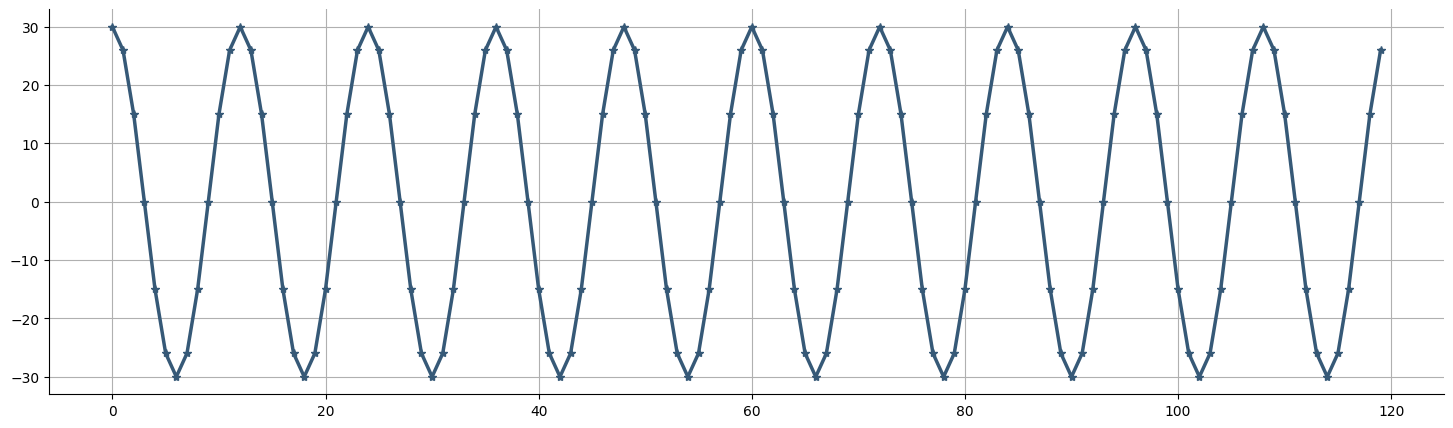

In [9]:
# 12 Werte zur Erstellung eines saisonalen Effekts
# die Kosinusfunktion wurde verwendet, eine Amplitude von 5 eingestellt
# der Mittelwert der Saisonkomponente über ein Jahr ist exakt null.

season = []
for i in range(12):
    season = season + [30* math.cos(math.pi*i/6)]

season = 10 * season   # wir brauchen 10 Jahre
    
plt.plot(season, marker='*')
plt.grid();

**Erzeugung Residuals**

In [10]:
sigma = 5
mu    = 3
resid = sigma * np.random.randn(120) + mu
resid[0:3]

array([-0.51552054,  0.5553084 ,  3.36478861])

**Additive Zusammensetzung der Komponenten**

In [11]:
# np.add arbeitet nur mit 2 Objekten
ts_add = np.add(trend, season)
ts_add = np.add(ts_add, resid)

**Erzeugung Dataframe**

In [12]:
df = pd.DataFrame( {'trend':  trend,
                    'season': season,
                    'resid':  resid,
                    'ts_add': ts_add },
                  index = dti)
df.head(2)

,trend,season,resid,ts_add
2010-01-01,30,30.000000,-0.515521,59.484479
2010-02-01,32,25.980762,0.555308,58.536071


''

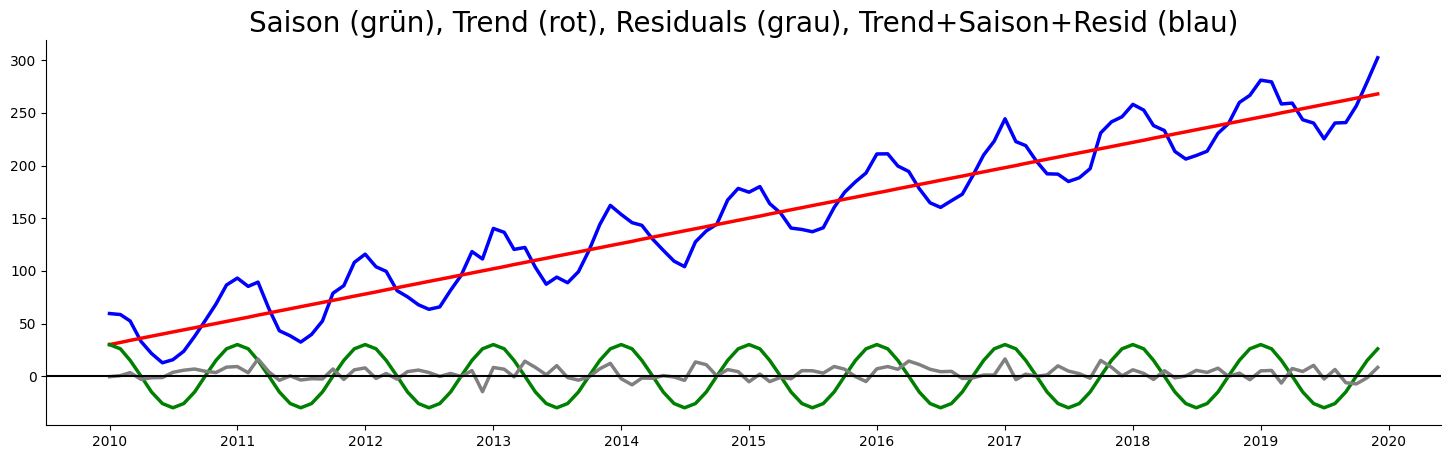

In [13]:
# Plot
plt.title('Saison (grün), Trend (rot), Residuals (grau), Trend+Saison+Resid (blau)', size=20)
plt.plot(df.ts_add, color = 'blue')
plt.plot(df.trend, color = 'red')
plt.plot(df.season, color = 'green')
plt.plot(df.resid, color = 'grey')
plt.axhline(y=0, color='black', linestyle='-', linewidth= 1.5)
;

## Trend und Saison: multiplikativ

**Es ist wahrscheinlicher, dass der saisonale Anteil mit der Höhe des Trends auch größer wird.**<br>
**Ein multiplikativer Trend besteht aus (dimensionslosen) Faktoren.**<br>
**Diese Faktoren sind in der Größenordnung von 1 (100%=durchschnittlicher Monat).**

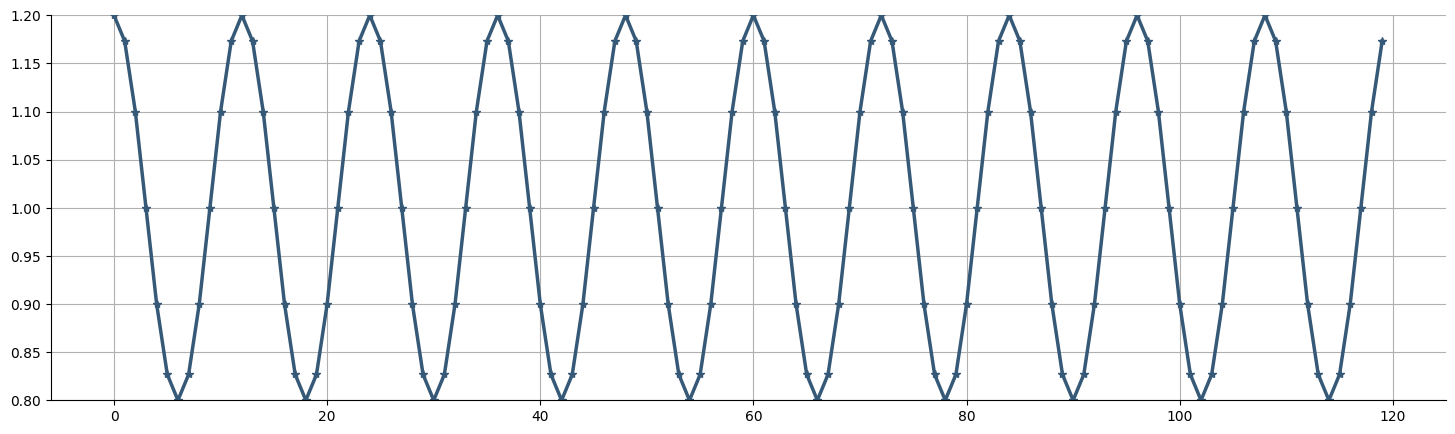

In [14]:
# 12 Faktoren zur Erstellung eines multiplikativen saisonalen Effekts.
# Die Kosinusfunktion wurde verwendet, mit Mittelwert von 1 und Amplitude von 0.1
# der Mittelwert der Saisonkomponente über ein Jahr ist exakt 1.

season_m = []
for i in range(12):
    season_m = season_m + ([0.2 * math.cos(math.pi*i/6) + 1])

season_m = 10 * season_m   # wir brauchen 10 Jahre

plt.plot(season_m, marker='*')
plt.ylim([0.8, 1.2])
plt.grid();

In [15]:
# Bei der multiplikativen Verknüpfung der Residuen müssen die auch im Bereich von 1 liegen.

sigma = 0.02
mu    = 1
resid_m = (sigma * np.random.randn(120) + mu)


In [16]:
# Multiplikative Verknüpfung der Komponenten
ts_m = np.multiply(trend, season_m)
ts_m = np.multiply(ts_m, resid_m)

df['season_m'] = season_m
df['resid_m']  = resid_m
df['ts_m']     = ts_m

''

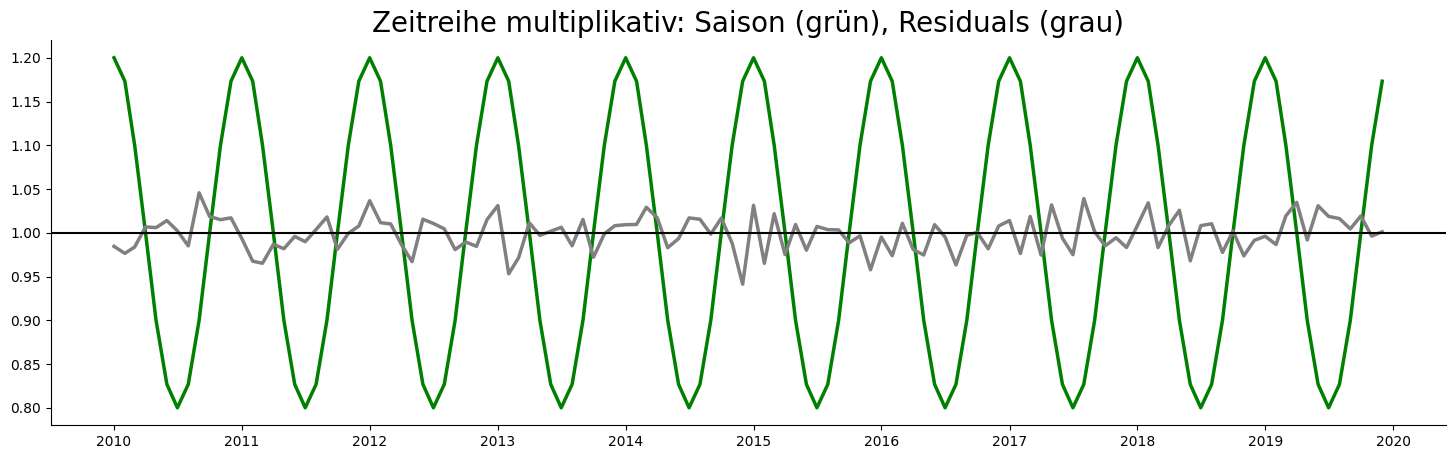

In [17]:
# Plot
plt.title('Zeitreihe multiplikativ: Saison (grün), Residuals (grau)', size=20)
plt.plot(df.season_m, color = 'green')
plt.plot(df.resid_m, color = 'grey')
#plt.axhline(y=0, color='black', linestyle='-', linewidth= 1.5)
plt.axhline(y=1, color='black', linestyle='-', linewidth= 1.5)
;

''

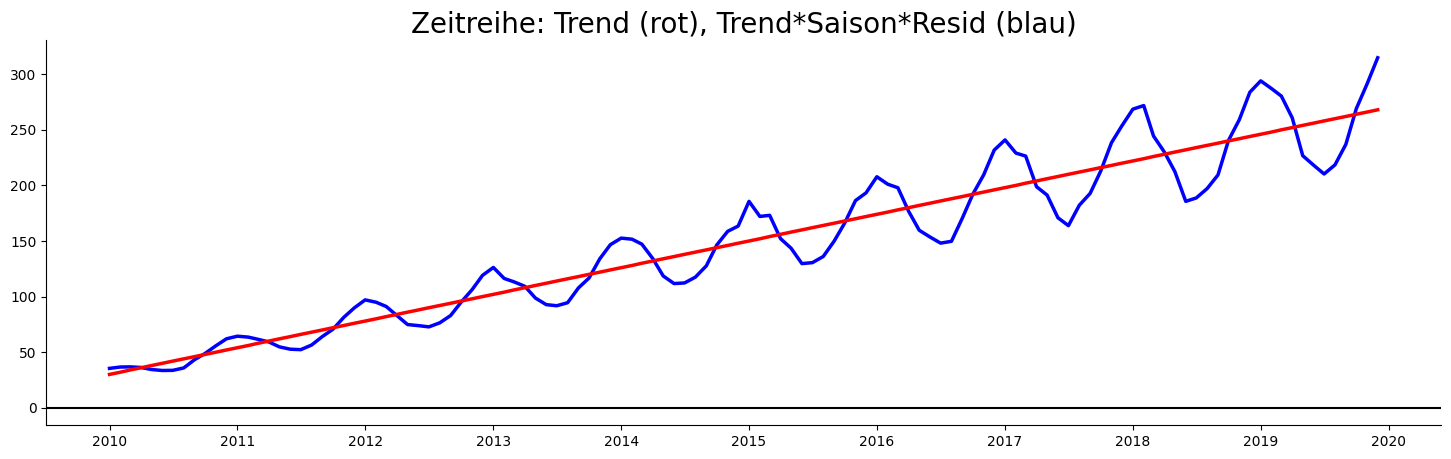

In [18]:
# Plot
plt.title('Zeitreihe: Trend (rot), Trend*Saison*Resid (blau)', size=20)
plt.plot(df.ts_m, color = 'blue')
plt.plot(df.trend, color = 'red')
plt.axhline(y=0, color='black', linestyle='-', linewidth= 1.5)
;

# Zeitreihendekomposition

https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

**seasonal_decompose()**  
<b>
* This is a naive decomposition. More sophisticated methods should be preferred.
</b>
* The additive model is Y[t] = T[t] + S[t] + e[t]
* The multiplicative model is Y[t] = T[t] * S[t] * e[t]
* The results are obtained by first estimating the trend by applying a convolution filter to the data.
* The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.

**Entscheident für die Qualität der Zeitreihendekomposition ist die Größe der Residuals!**

In [19]:
# Change the default figsize
rcParams['figure.figsize'] = 12, 8

## Add. Dekomp. add. Modell

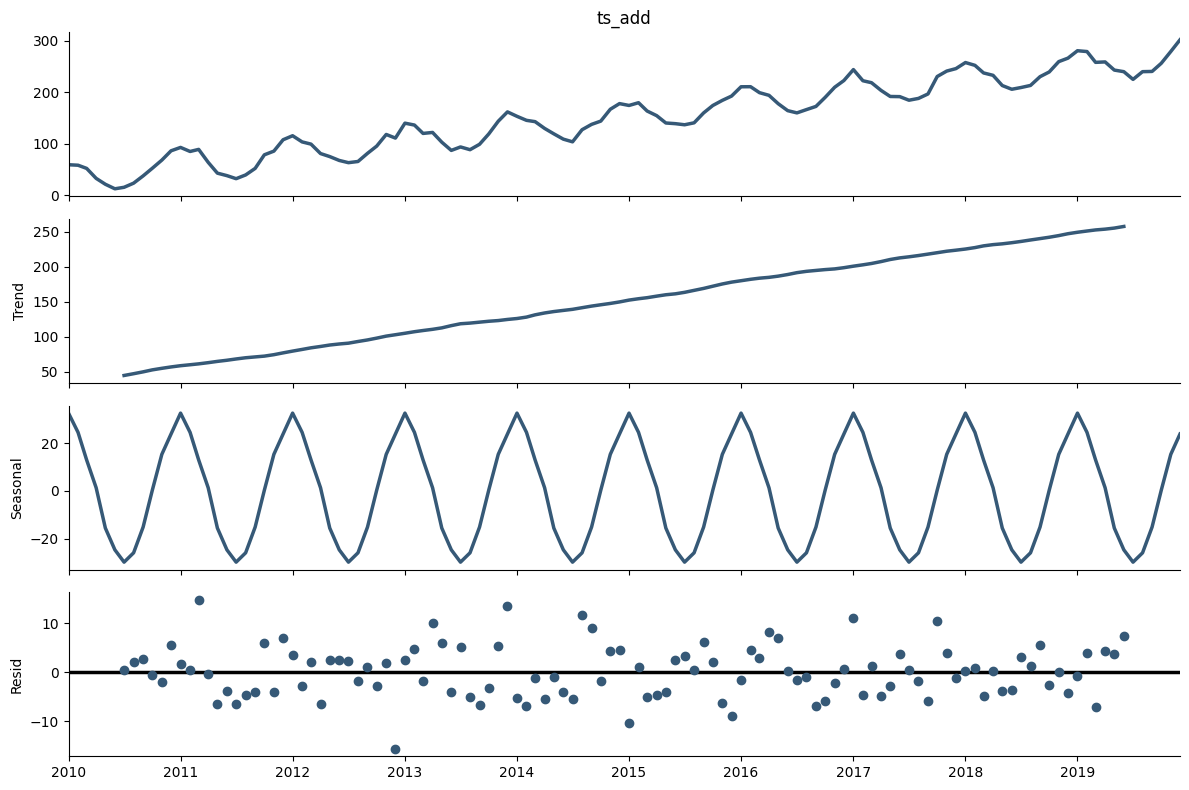

In [20]:
# Decompose and plot
decomposed = seasonal_decompose(df['ts_add'],model = 'additional')
decomposed.plot();

## Mult. Dekomp. mult. Modell

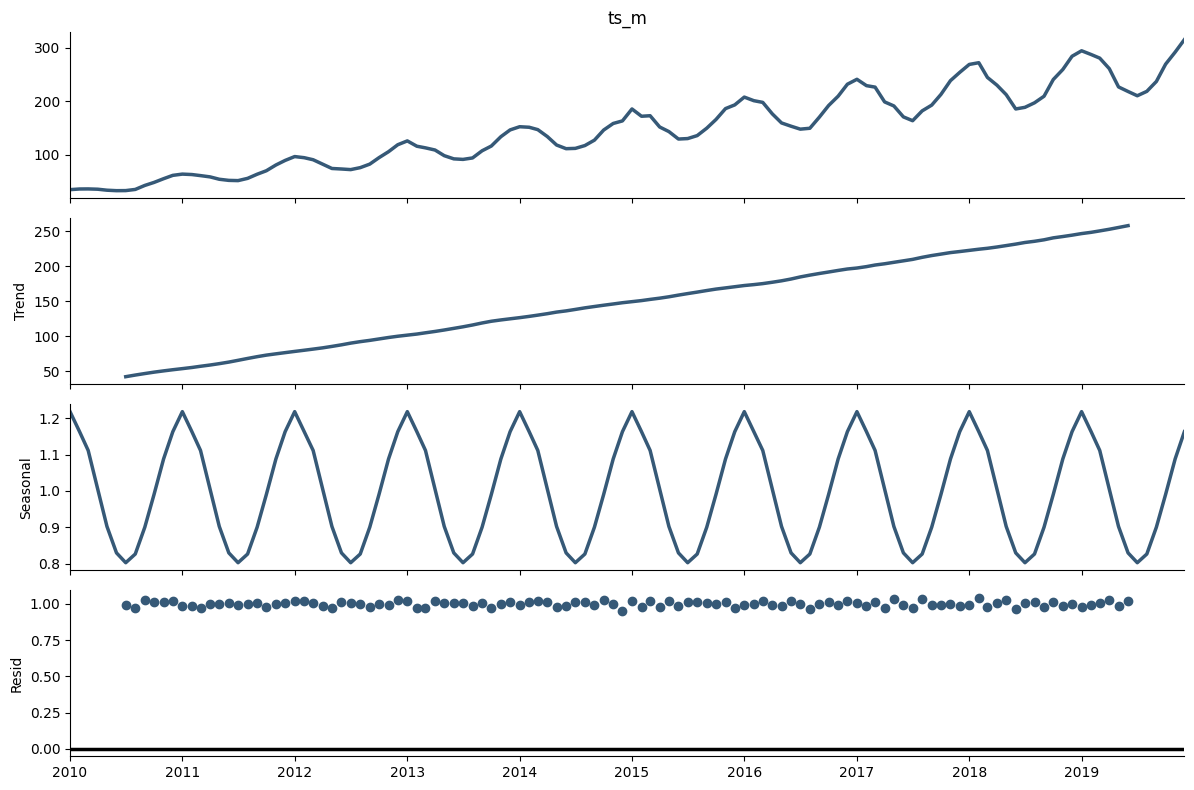

In [21]:
# Decompose and plot
decomposed = seasonal_decompose(df['ts_m'],model = 'multiplicative')
decomposed.plot();

## Add. Dekomp. mult. Modell

**Dekomposition des multiplikativ zusammengesetzten Modell mit dem additiven Modell**

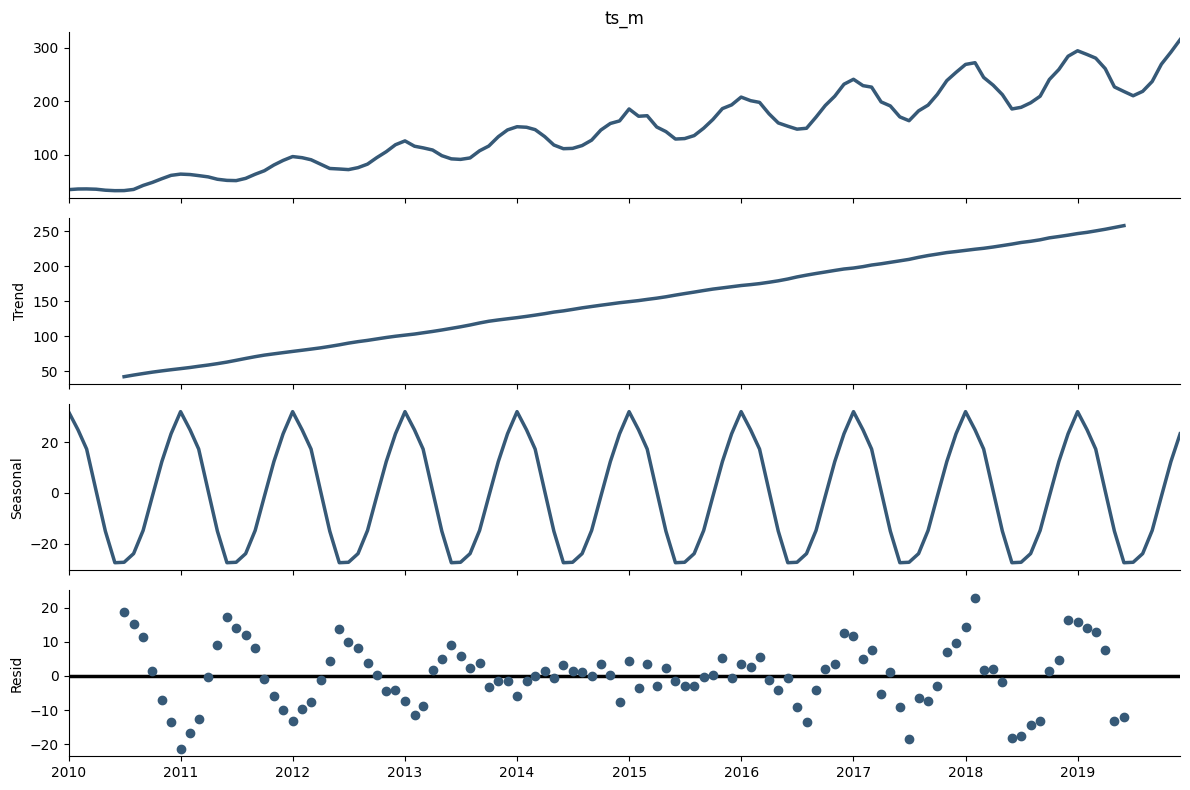

In [22]:
# Decompose and plot
decomposed = seasonal_decompose(df['ts_m'],'additive')
decomposed.plot();

## Mult. Dekomp. add. Modell

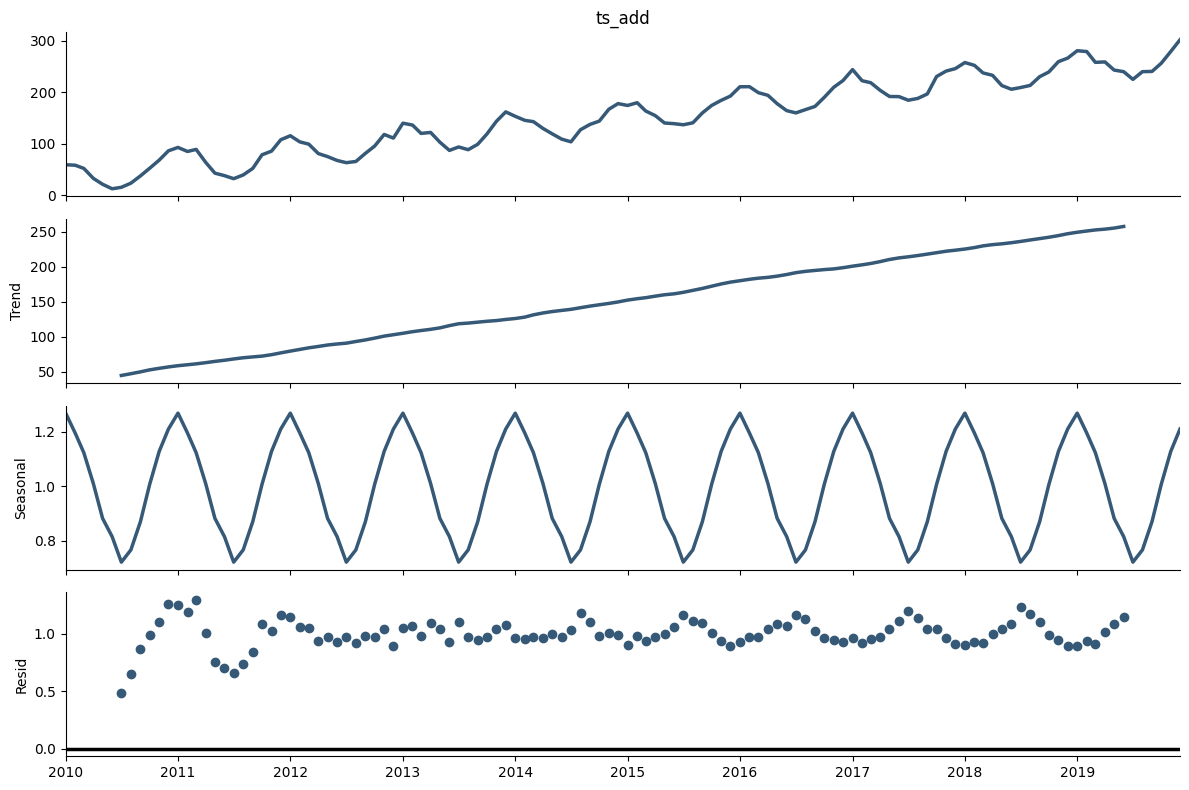

In [23]:
# Decompose and plot
decomposed = seasonal_decompose(df['ts_add'],model = 'multiplicative')
decomposed.plot();

# Dekomposition Passagierdaten

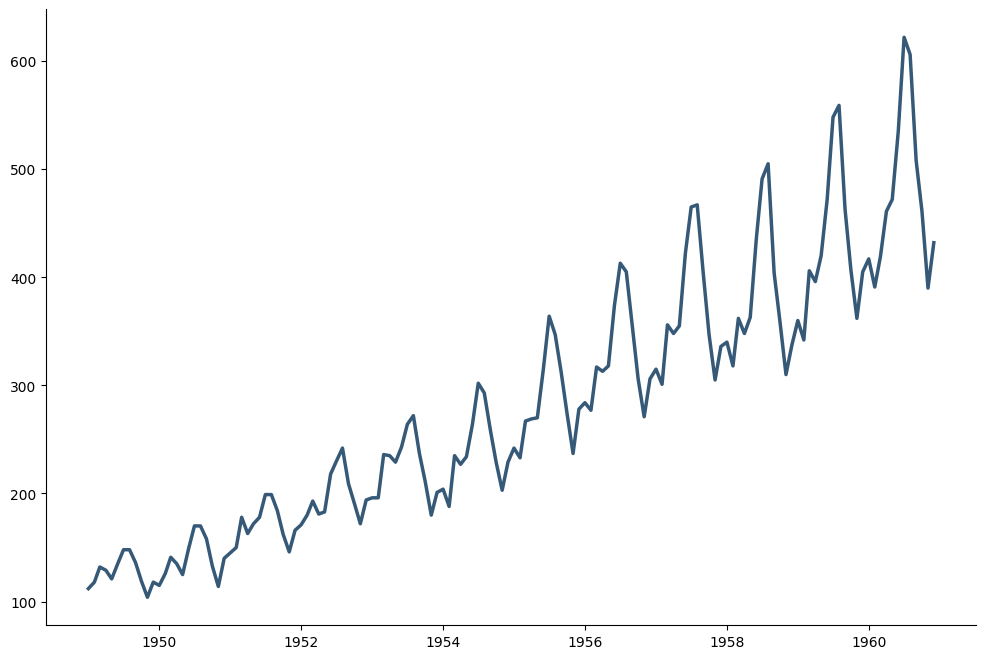

In [24]:
plt.plot(passengers.Passengers);

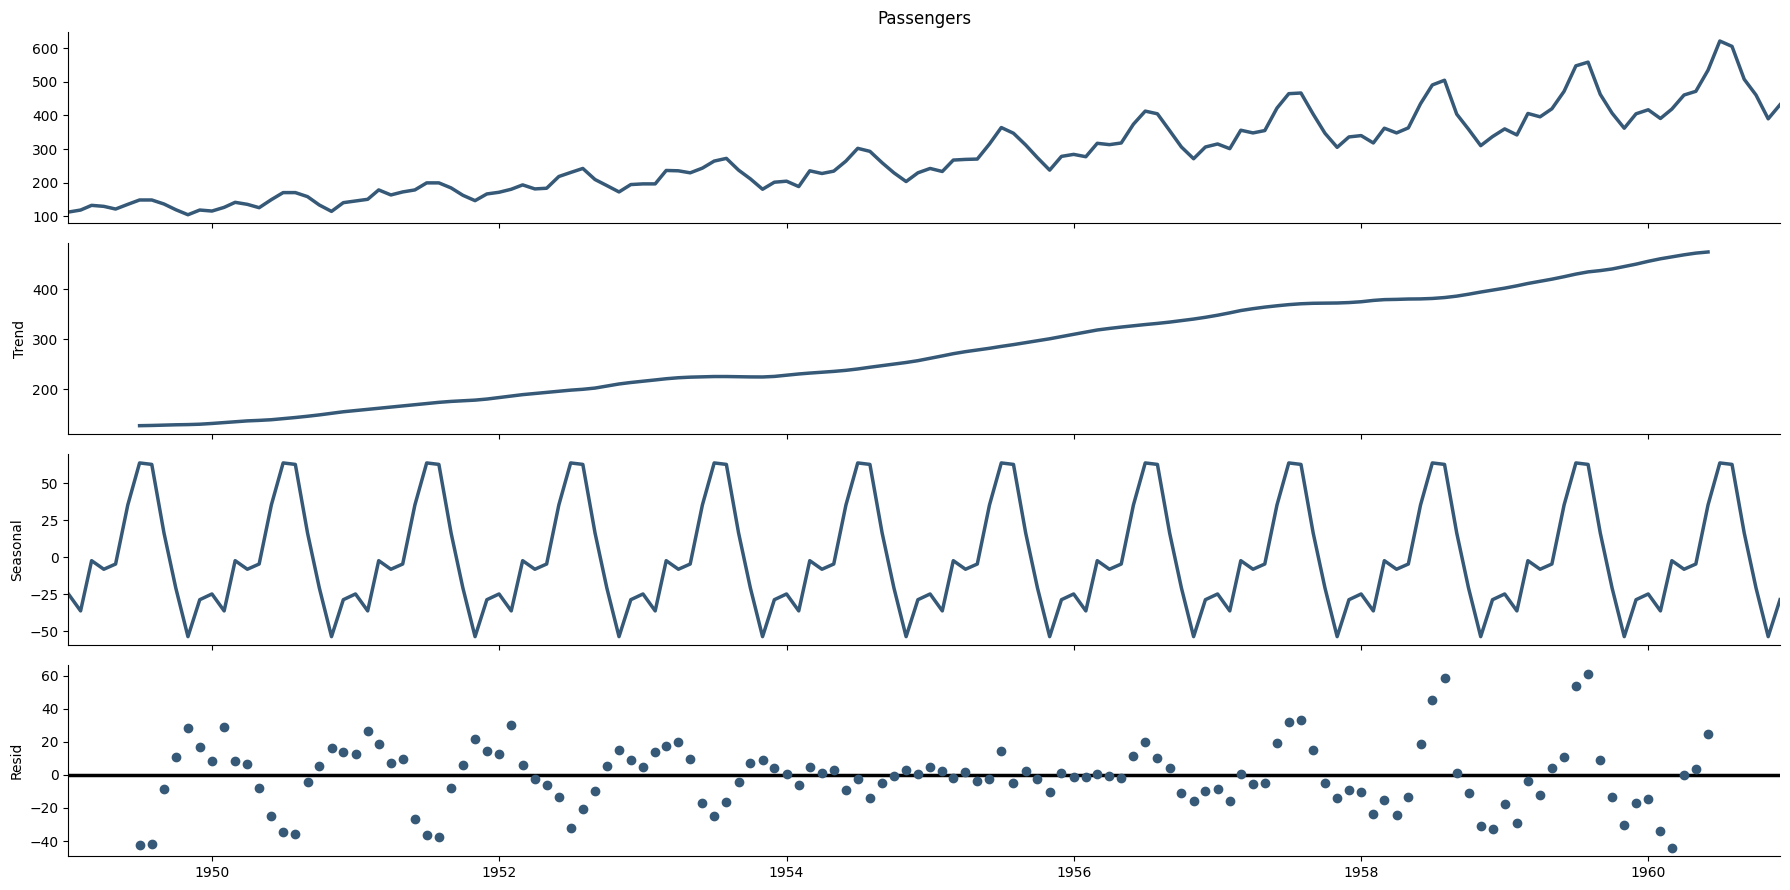

In [25]:
# Decompose and plot
rcParams['figure.figsize'] = 18, 9
decomposed = seasonal_decompose(passengers.Passengers,model = 'additive')
decomposed.plot();

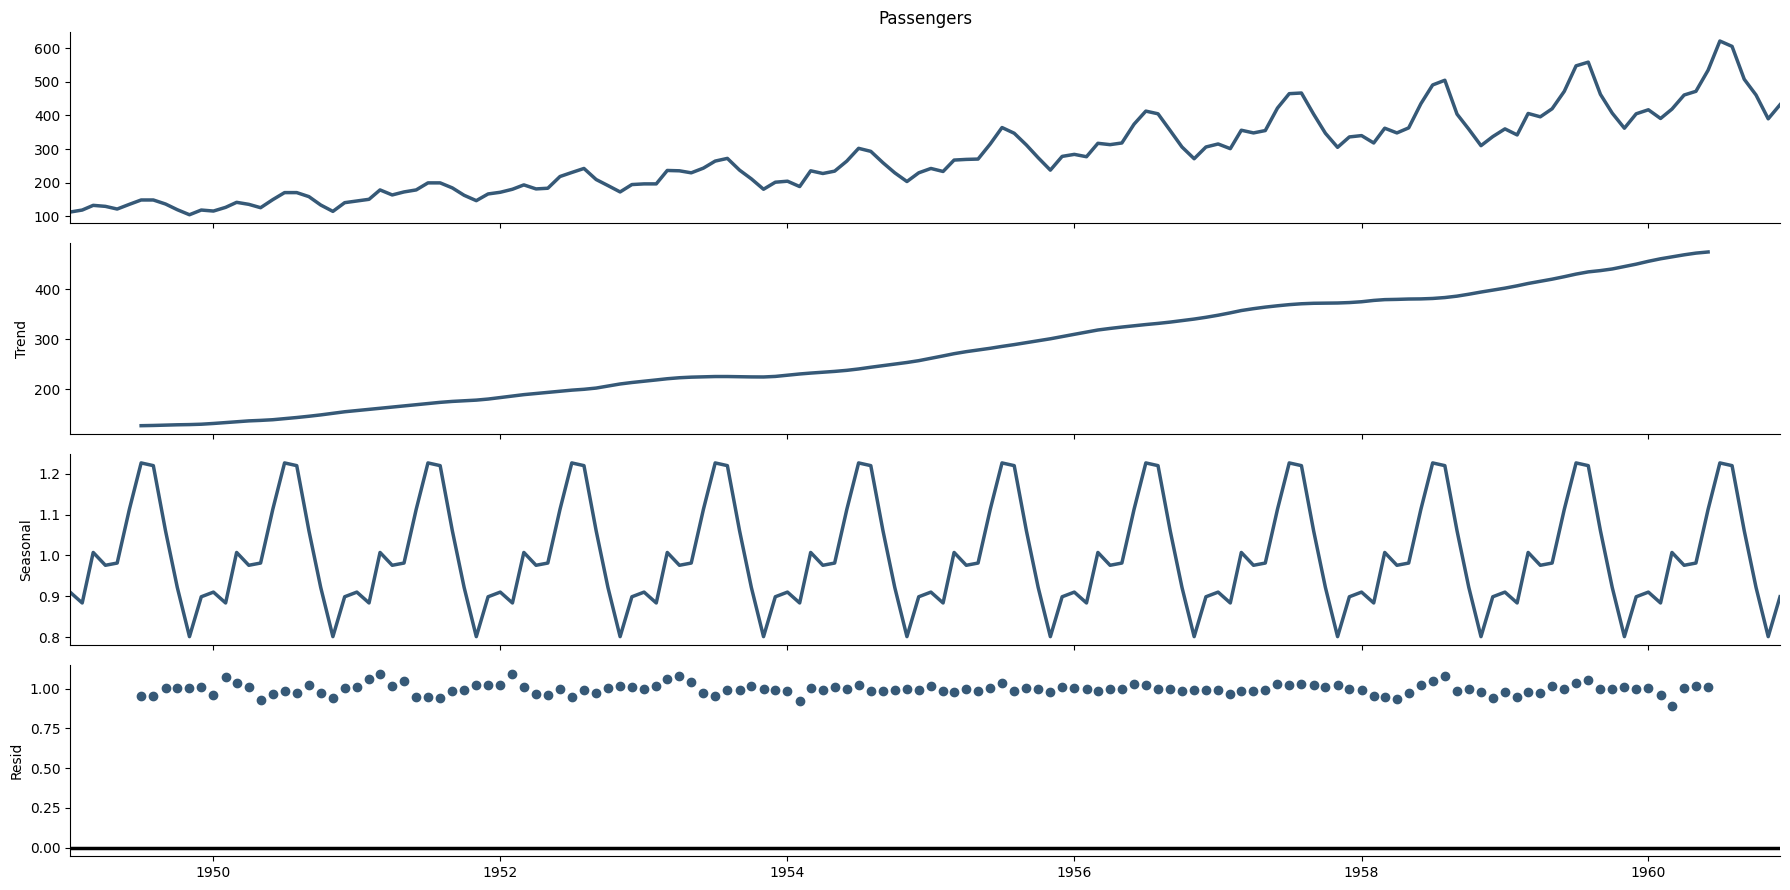

In [26]:
# Decompose and plot
decomposed = seasonal_decompose(passengers.Passengers,model = 'multiplicative')
decomposed.plot();

# Konklusio

**Zeitreihendekomposition**  
<ul>
<li>ist ein Tool um historischen Daten zu analysieren
<li>es ist darauf zu achten, ob ein additiver oder ein multiplikativer Zusammenhang besteht
<li>dient zur Beurteilung ob ein (signifikanter) saisonaler Anteil vorhanden ist
<li>aus den einzelnen Komponenten lassen sich einfach forecasts erstellen, die dann wieder zum gesamten Forecast zusammengesetzt werden
</ul>

# Aufgaben

**Führe eine Zeitreihendekomposition mit den Verkaufszahlen durch.**  
**Teste das additive und auch das multiplikative Modell.**  
**Beurteile den Trend- und die Saisonkomponente.**